# Incremental margin algorithm for large margin classifiers

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.datasets import load_digits
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from scipy.stats import sem
from numpy import linalg as LA
from copy import deepcopy
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from numba import jit, cuda
import warnings
warnings.filterwarnings("ignore")

## Calculating the margin

In [2]:
def compute_margin(X, y, w, b):
    margin = []
    for i in range(y.shape[0]):
        margin.append((y[i]*(np.dot(X[i,:], w)+b))/sqrt(sum(w**2))) 
    if min(margin) >= 0:
        return min(margin)
    return 0

## L0 norm

In [3]:
def L0_norm(w, threshold):
    l0_norm = 0
    for wi in w:
        if abs(wi) > threshold:
            l0_norm += 1
    return l0_norm

## RBFNN with IM

In [4]:
import random
from sklearn.base import BaseEstimator, ClassifierMixin
class RBF_IMA(BaseEstimator, ClassifierMixin):

    # Inicialization of important parameters 
    def __init__(self, n_neurons, eta=0.1, lambda_param=0.01, delta_margin=10^-3,
                 IMA_iterations=10, max_updates=10000, p='2'):
        self.n_neurons = n_neurons              # Neurons of hidden layer osf RBF
        self.eta = eta                          # Learning rate
        self.lambda_param = lambda_param        # Param important of soft margin
        self.delta_margin = delta_margin        # (1 + delta_margin) * fixed margin defines the minimum next margin of IMA
        self.IMA_iterations = IMA_iterations    # Maximum number of iterations of IMA
        self.max_updates = max_updates          # Maximum number of updates in one execution of FMP
        self.w = np.array([])                   # Vector of weights of the last layer of the RBF obtained after the training of the IMA
        self.w_rbf = np.array([])               # Vector of weights of the last layer of the RBF obtained after the normal training of RBF
        self.H = np.array([])                   # H matrix of RBF (obtained with training data)
        self.Z = np.array([])                   # Z matrix of RBF
        self.b = 0
        self.p = p 

    @staticmethod
    @jit(target_backend='cuda')    
    def pdfnvar(pairwise_dist, sigma):
        return np.exp(-pairwise_dist ** 2 / (2 * sigma ** 2))

    # Fixed Margin Algorithm
    @staticmethod
    @jit(target_backend='cuda')    
    def FMP_algorithm(X, y, w_init, b_init, fixed_margin, idx, s, lambda_param, eta, max_updates, p):
        t = 0
        iterations = 0
        w = w_init
        b = b_init
        if p == 'inf':
            norm_w = LA.norm(w, ord=1)
        elif p == '1':
            norm_w = LA.norm(w, ord=np.inf)
        else: # p == 2
            norm_w = sqrt(sum(w**2))
        
        last_t = -1
        lambda_t = 0
        alpha = np.zeros((X.shape[0]))
        while True:
            last_t = t
            e=0
            for k in range(0, y.shape[0]):
                i = int(idx[k])
                if(y[i]*(np.dot(X[i,:], w)+b) <= fixed_margin * norm_w - lambda_param * alpha[i]):
                    if norm_w != 0:
                        lambda_t = 1 - (eta*fixed_margin)/norm_w
                    else:
                        lambda_t = 1
                    alpha = alpha * lambda_t
                    alpha[i] = alpha[i] + eta  
                    if p == 'inf':
                        w = w - eta * (fixed_margin * np.sign(w) - y[i] * X[i,:])
                        norm_w = LA.norm(w, ord=1)
                    elif p == '1':
                        for j in range(len(w)):
                            if abs(w[j]) == norm_w:
                                w[j] = w[j] - eta * (fixed_margin * np.sign(w[j])/sum(np.abs(w) == norm_w) - y[i] * X[i,j])
                            elif abs(w[j]) < norm_w:
                                w[j] = w[j] + eta * (y[i] * X[i,j])
                        norm_w = LA.norm(w, ord=np.inf)
                    else: # p == 2
                        w = w * lambda_t + eta * y[i] * X[i,:]
                        norm_w = sqrt(sum(w**2))
                    b = b + eta*y[i]
                    t += 1
                    e += 1
                    if k > s:
                        s += 1
                        j = s
                    else:
                        j=e
                    idx[k], idx[j] = idx[j], idx[k]
            iterations += 1
            if (t > max_updates or last_t == t):
                break
        if t<= max_updates:
            convergence=1
        else:
            convergence=0
        return w, b, convergence, t, iterations, idx, s

    # IMA Algorithm
    def IM_algorithm(self, X, y):
        self.w = np.ones(self.w_rbf.shape[0]) * 0.000001
        self.ws = [] 
        self.bs = [] 
        self.ws.append(self.w)
        self.bs.append(self.b)
        fixed_margin = 0#compute_margin(X, y, self.w_RBF, self.b)
        t = 0
        convergence = 1
        updates=0
        iterations=0
        margin=[]
        margin.append(fixed_margin)
        idx = np.linspace(0, y.shape[0]-1, y.shape[0])
        s=0
        while convergence==1 and t<self.IMA_iterations:
            w, b, convergence, updates_, iterations_, idx, s = self.FMP_algorithm(X, y, self.w, self.b, fixed_margin, idx, s, self.lambda_param, self.eta, self.max_updates, self.p)
            if convergence == 1:
                self.w = w
                self.b = b
                self.ws.append(self.w)
                self.bs.append(self.b)
            updates += updates_
            iterations += iterations_
            
            if self.p == 'inf':
                norm_w = LA.norm(w, ord=1)
            elif self.p == '1':
                norm_w = LA.norm(w, ord=np.inf)
            else: # p == 2
                norm_w = sqrt(sum(w**2))
            
            gamma1 = []
            gamma2 = []
            for i in range(0, y.shape[0]):
                if y[i] == 1:
                    gamma1.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
                else:
                    gamma2.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
            gamma1 = np.array(gamma1)
            gamma2 = np.array(gamma2)
            gamma1 = gamma1[gamma1>=0]
            gamma2 = gamma2[gamma2>=0]
            if len(gamma1) == 0:
                min_gamma1 = 0
            else:
                min_gamma1 = min(gamma1)
            if len(gamma2) == 0:
                min_gamma2 = 0
            else:
                min_gamma2 = min(gamma2)
            fixed_margin = max([(min_gamma1 + min_gamma2)/2, (1+self.delta_margin)*fixed_margin])
            #margin.append(compute_margin(X, y, self.w, self.b))
            t += 1
        return t, updates, iterations, margin

    # Function that manage the training of IMA RBF
    def fit(self, X, y):
        N = X.shape[0] # number of samples
        n = X.shape[1] # samples dimension
        # Applying K-mean to separate the clusters:
        kmeans = KMeans(n_clusters=self.n_neurons).fit(X)
        # Capture the centers:
        self.centers = kmeans.cluster_centers_

        pairwise_dist = pairwise_distances(X, self.centers)

        self.sigma = np.mean(np.mean(pairwise_dist, axis=1))
        
        self.H = self.pdfnvar(pairwise_dist, self.sigma)

        #self.H = np.hstack((self.H, np.ones((self.H.shape[0], 1))))

        self.w_rbf = np.dot(np.linalg.pinv(self.H), y)
        
        iterations_IMA, updates, iterations, margin = self.IM_algorithm(self.H, y) 
        
        return iterations_IMA, updates, iterations, margin
            
    # Function to apply IMA RBF model
    def predict(self, X, use_IMA_w=True):
        pairwise_dist = pairwise_distances(X, self.centers)
        H = self.pdfnvar(pairwise_dist, self.sigma)
        #H = np.hstack((H, np.ones((H.shape[0], 1))))
        if use_IMA_w == True:
            y_predicted = np.sign(np.dot(H, self.w) + self.b)
        else:
            y_predicted = np.sign(np.dot(H,  self.w_rbf))
        y_predicted[y_predicted==0]=-1
        return y_predicted

## Function to Capture Results

In [5]:
def results(X, y, p, eta, IMA_iterations, lambda_param):  
    # Normalizing data:
    normalizer = MinMaxScaler()
    X = normalizer.fit_transform(X)
           
    print(f'Parameters: p={p}, eta={eta}, lambda={lambda_param}')
    # Stratified k fold cross validation
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=72)
    
    # IM RBF
    clf = RBF_IMA(n_neurons=p, eta=eta, lambda_param=lambda_param, delta_margin=10^-3, IMA_iterations=IMA_iterations, max_updates=10000, p='2')
    clf.fit(X_train, y_train)
    w_2 = clf.w
    Z = clf.Z
    norm_w = LA.norm(w_2, ord=2)
    w_2 = w_2/norm_w
    
    # RBF
    w_rbf = clf.w_rbf
    norm_w = LA.norm(w_rbf, ord=2)
    w_rbf = w_rbf/norm_w
    
     # IM RBF p1
    clf = RBF_IMA(n_neurons=p, eta=eta, lambda_param=lambda_param, delta_margin=10^-3, IMA_iterations=IMA_iterations, max_updates=10000, p='1')
    clf.fit(X_train, y_train)
    w_1 = clf.w
    norm_w = LA.norm(w_1, ord=2)
    w_1 = w_1/norm_w
    
    # IM RBF p inf
    clf = RBF_IMA(n_neurons=p, eta=eta, lambda_param=lambda_param, delta_margin=10^-3, IMA_iterations=IMA_iterations, max_updates=10000, p='inf')
    clf.fit(X_train, y_train)
    w_inf = clf.w
    norm_w = LA.norm(w_inf, ord=2)
    w_inf = w_inf/norm_w
    return w_rbf, w_1, w_2, w_inf

In [6]:
def plot_weights(n, w_1, w_2, w_inf):
    x = np.linspace(1, n, n)
    fig = plt.figure(figsize=(7,6))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.bar(x, w_1, color="darkblue")
    ax1.set_title(r"$RP-IMA_1$", fontsize=16, fontweight='bold')
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.bar(x, w_2, color="darkblue")
    ax2.set_title(r"$RP-IMA_2$", fontsize=16, fontweight='bold')
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.bar(x, w_inf, color="darkblue")
    ax3.set_title(r"$RP-IMA\infty$", fontsize=16, fontweight='bold')
    # Set common labels
    fig.text(0.5, -0.02, 'Network weights', ha='center', va='center', fontsize=16)
    fig.text(0, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical', fontsize=16)

    fig.tight_layout()
    plt.show

## Application on Iris Dataset


Parameters: p=50, eta=0.1, lambda=0.01


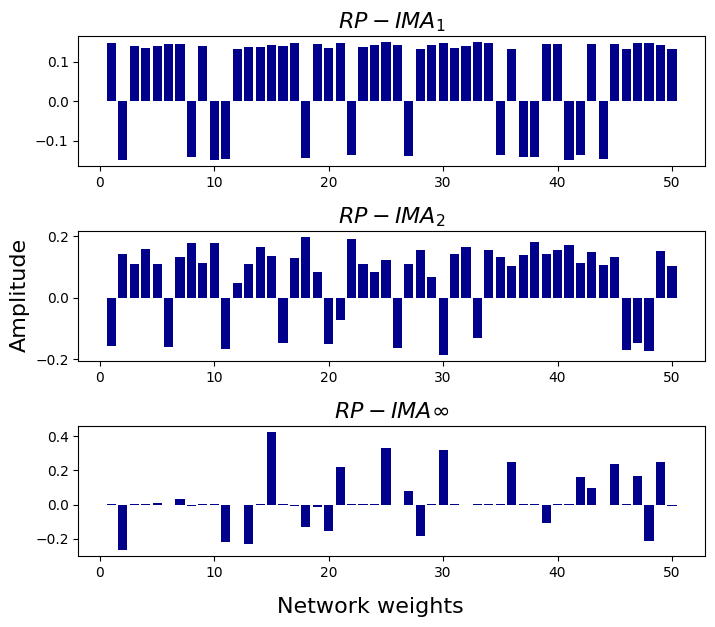

In [30]:
iris = datasets.load_iris()
X = iris.data
# setosa - 0, versicolor - 1, virginica - 2  
y = iris.target 
# O problema agora possui apenas as classes y=-1 e y=1
y[y>0] = 1
y[y==0] = -1
w_rbf, w_1, w_2, w_inf = results(X, y, 50, 0.1, 20, 0.01)
plot_weights(50, w_1, w_2, w_inf)

## Application on Synthetic Dataset

Parameters: p=200, eta=0.1, lambda=0.01


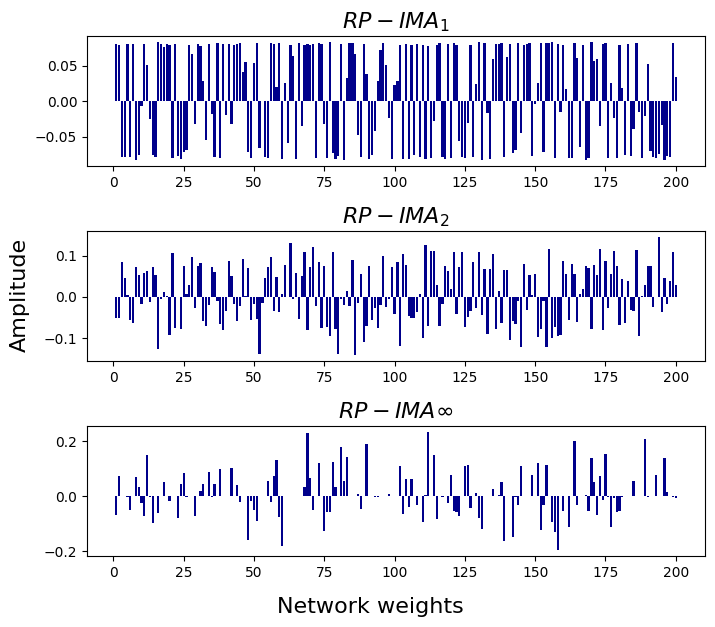

In [8]:
synthetic_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/synthetic_dataset/synthetic_control.data', sep="\s+",  header=None, engine='python')
X = synthetic_dataset.to_numpy()
y = np.concatenate((np.ones(100), np.ones(200)*-1, np.ones(100), np.ones(100)*-1,np.ones(100)))
w_rbf, w_1, w_2, w_inf = results(X, y, 200, 0.1, 20, 0.01)
plot_weights(200, w_1, w_2, w_inf)

## Application on Robot  Dataset



Parameters: p=39, eta=0.1, lambda=0.01


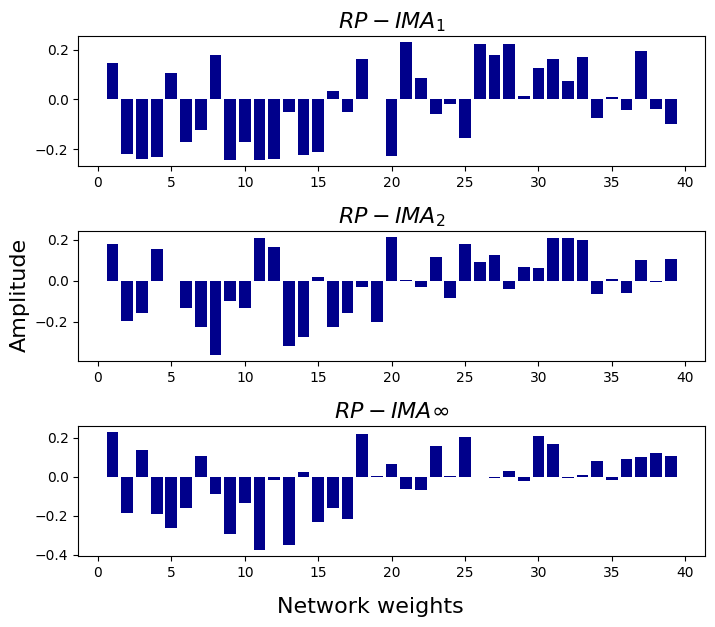

In [39]:
robot_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/robot/lp4_data.csv', delimiter =',')
X = robot_dataset.to_numpy().reshape([117,90])
y = np.concatenate((np.ones(24), np.ones(117-24)*-1))
w_rbf, w_1, w_2, w_inf = results(X, y, 39, 0.1, 20, 0.01)
plot_weights(39, w_1, w_2, w_inf)

## Application on Mushroom Dataset

Parameters: p=333, eta=0.1, lambda=1


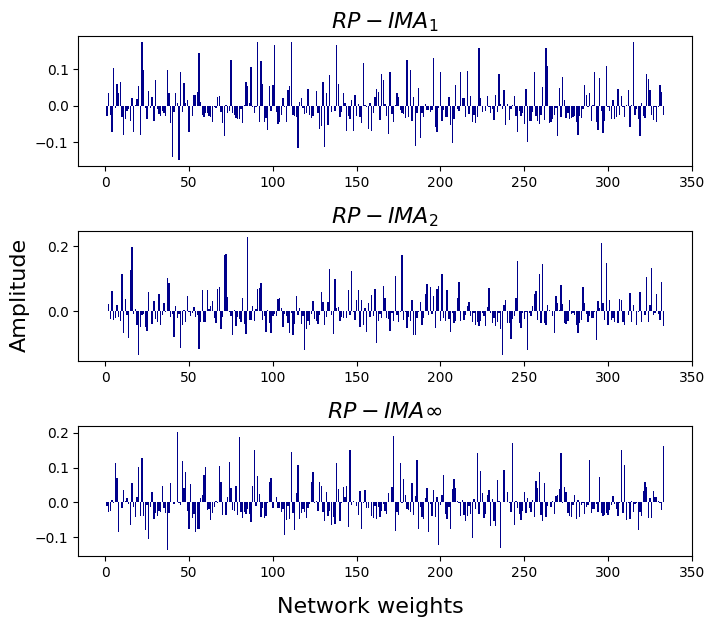

In [40]:
df = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/Mushroom/agaricus-lepiota.data', delimiter =',', header=None)
df = df.replace("?", np.nan) 
df = df.dropna() 
y = df[0].to_numpy()
X = df.drop([0], axis='columns')
X = pd.get_dummies(X).to_numpy()
y[np.where(y=='e')] = -1
y[np.where(y=='p')] = 1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 333, 0.1, 20, 1)
plot_weights(333, w_1, w_2, w_inf)

## Application on Ionosphere Dataset

Parameters: p=117, eta=0.1, lambda=1


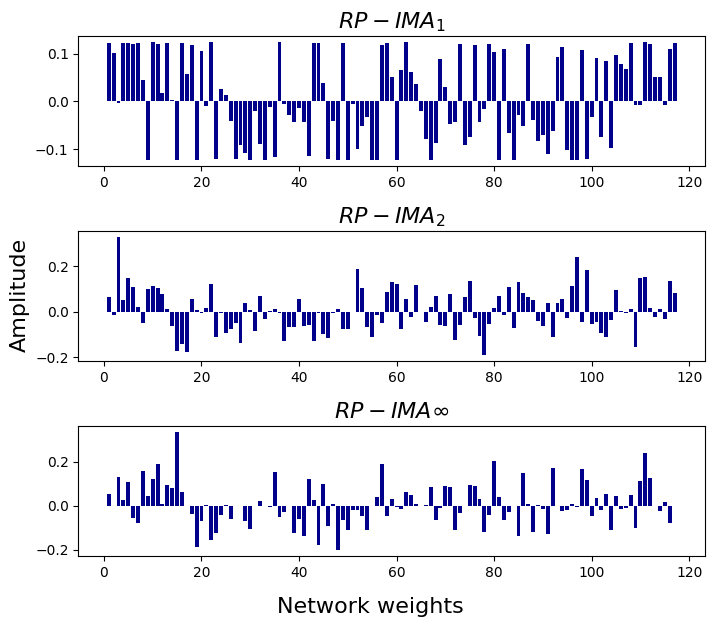

In [41]:
ionosphere_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/Ionosphere/ionosphere.data', names=list(range(0,35)), sep=',')
y = ionosphere_dataset[34].to_numpy()
X = ionosphere_dataset.drop([34], axis='columns').to_numpy()
y[np.where(y=='g')] = 1
y[np.where(y=='b')] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 117, 0.1, 20, 1)
plot_weights(117, w_1, w_2, w_inf)

## Application on Banknote Dataset

Parameters: p=333, eta=0.1, lambda=0.01


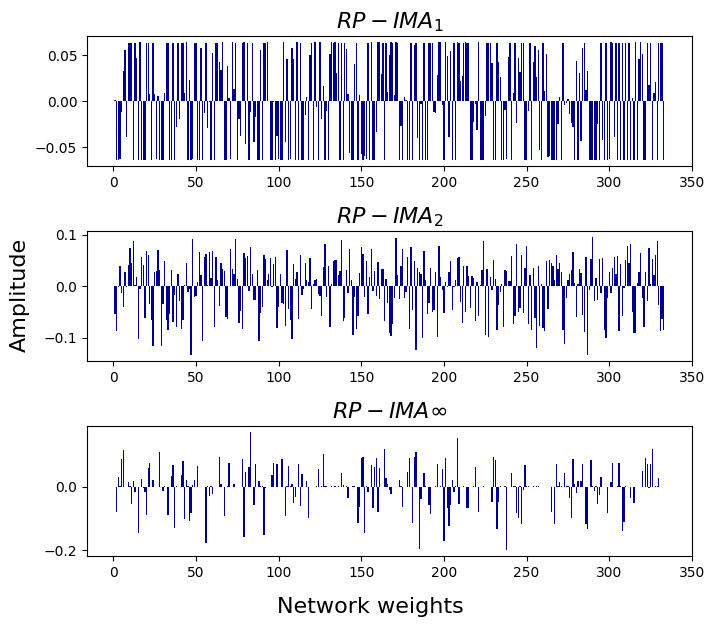

In [12]:
# read in banknote authentication set
banknotes = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/banknote/data_banknote_authentication.txt', names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

# convert to array
X = banknotes[['variance', 'skewness', 'curtosis', 'entropy']].to_numpy()
y = banknotes[['class']].to_numpy()
y[np.where(y==0)] = -1
w_rbf, w_1, w_2, w_inf = results(X, y, 333, 0.1, 20, 0.01)
plot_weights(333, w_1, w_2, w_inf)

## Application on Wine Dataset

Parameters: p=59, eta=0.1, lambda=1


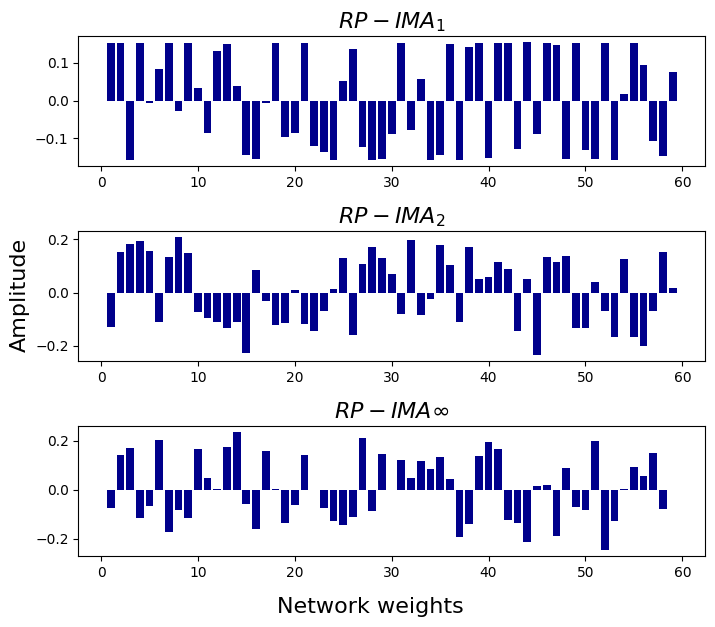

In [42]:
wine_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/wine/wine.data', names=['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315', 'Proline'])
# convert to array
y = wine_dataset[['Class']].to_numpy()
X = wine_dataset.drop("Class",axis='columns').to_numpy()
y[np.where(y==3)] = 1
y[np.where(y==2)] = -1
w_rbf, w_1, w_2, w_inf = results(X, y, 59, 0.1, 20, 1)
plot_weights(59, w_1, w_2, w_inf)

## Application on WDBC Dataset

Parameters: p=189, eta=0.1, lambda=1


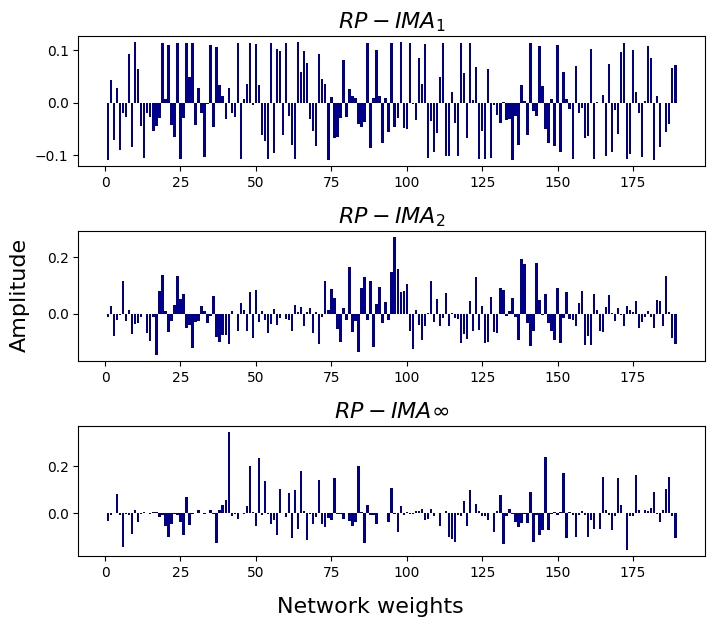

In [43]:
wdbc_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/WDBC/wdbc.data', names=list(range(0,32)))
# convert to array
y = wdbc_dataset[1].to_numpy()
X = wdbc_dataset.drop([0, 1],axis='columns').to_numpy()
y[np.where(y=='B')] = 1
y[np.where(y=='M')] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 189, 0.1, 20, 1)
plot_weights(189, w_1, w_2, w_inf)

## Application on Sonar Dataset

Parameters: p=69, eta=0.1, lambda=10


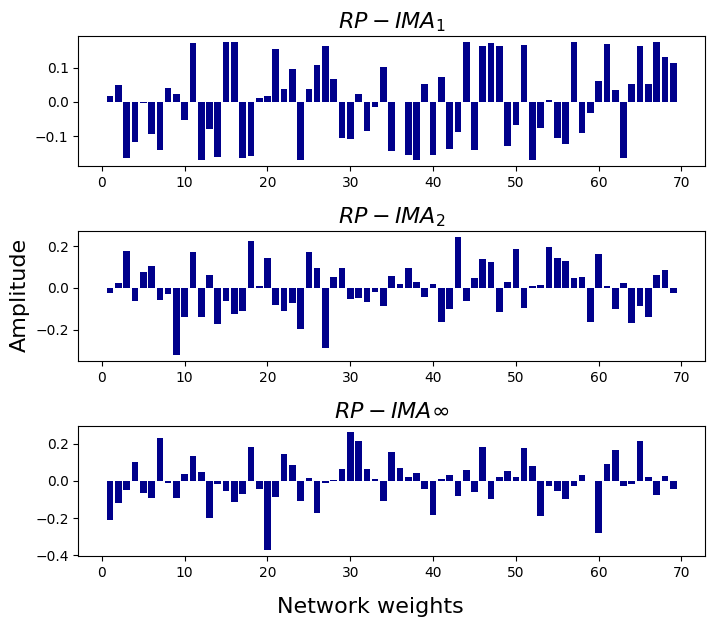

In [44]:
sonar_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/sonar/sonar.all-data', names=list(range(0,61)), sep=',')
y = sonar_dataset[60].to_numpy()
X = sonar_dataset.drop([60], axis='columns').to_numpy()
y[np.where(y=='R')] = 1
y[np.where(y=='M')] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 69, 0.1, 20, 10)
plot_weights(69, w_1, w_2, w_inf)

## Application on Pima Dataset

Parameters: p=256, eta=0.1, lambda=10


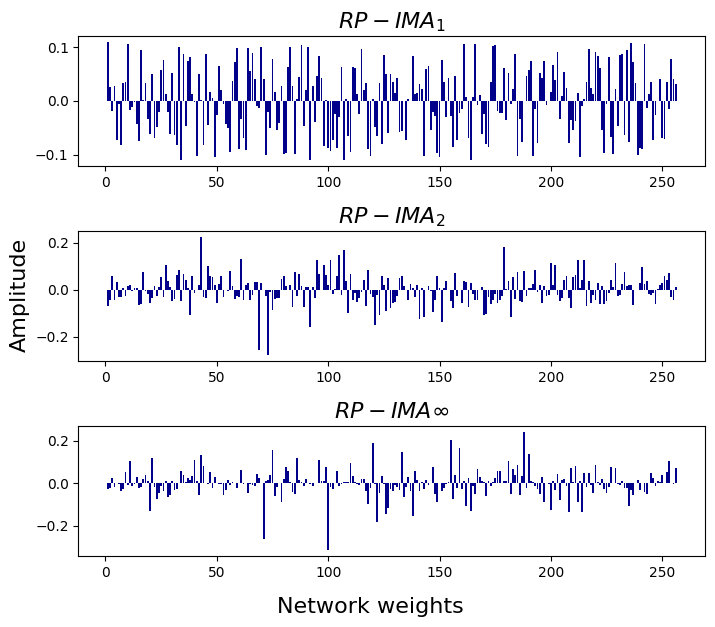

In [45]:
pima_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/diabetes/diabetes.csv', sep=",", engine='python')
y = pima_dataset['Outcome'].to_numpy()
X = pima_dataset.drop(['Outcome'], axis='columns').to_numpy()
y[np.where(y==0)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 256, 0.1, 20, 10)
plot_weights(256, w_1, w_2, w_inf)

## Application on Statlog Dataset

Parameters: p=90, eta=0.1, lambda=1


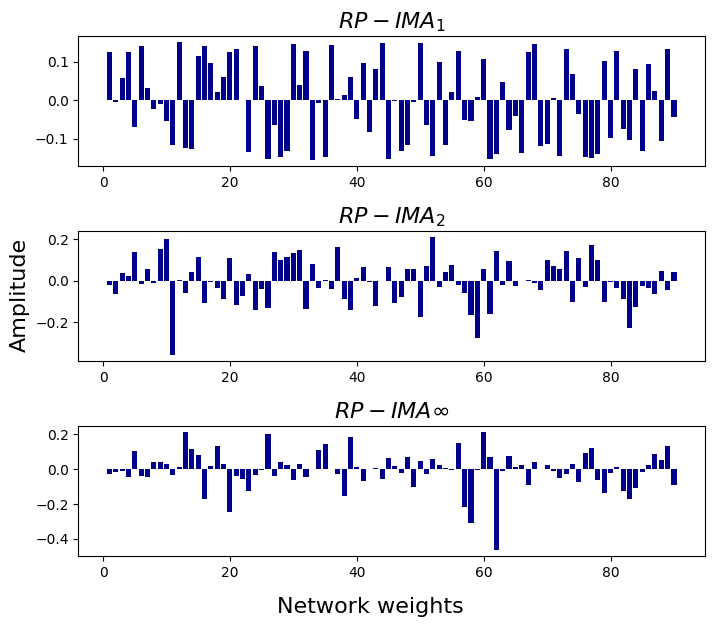

In [46]:
statlog_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/statlog/heart.dat', sep=" ", header=None, engine='python')
y = statlog_dataset[13].to_numpy()
X = statlog_dataset.drop([13], axis='columns').to_numpy()
y[np.where(y==2)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 90, 0.1, 20, 1)
plot_weights(90, w_1, w_2, w_inf)

## Application on Mammographic Dataset

Parameters: p=276, eta=0.1, lambda=10


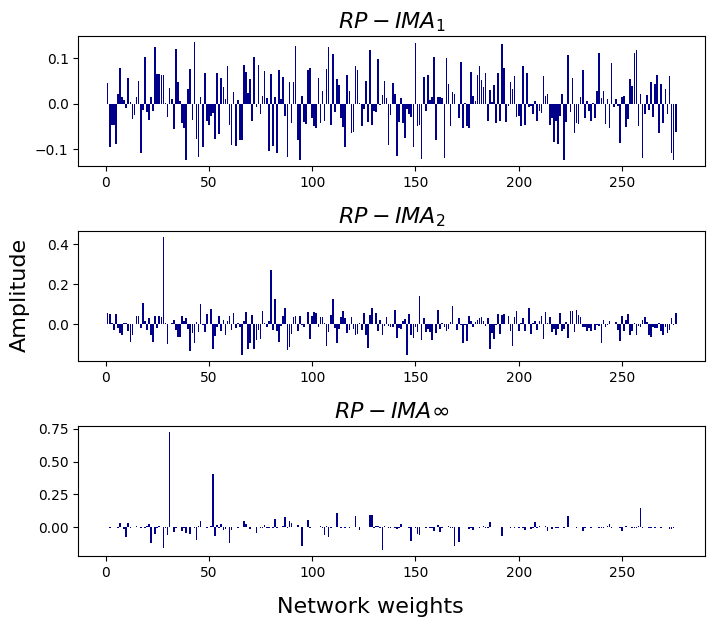

In [33]:
mammo = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/mammographic/mammographic_masses.data', sep=",", header=None, engine='python')
mammo = mammo.replace("?", np.nan)
mammo = mammo.dropna()
y = mammo[5].to_numpy()
X = mammo.drop([5], axis='columns').to_numpy()
y[np.where(y==0)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 276, 0.1, 20, 10)
plot_weights(276, w_1, w_2, w_inf)

## Application on Haberman Dataset

Parameters: p=102, eta=0.1, lambda=10


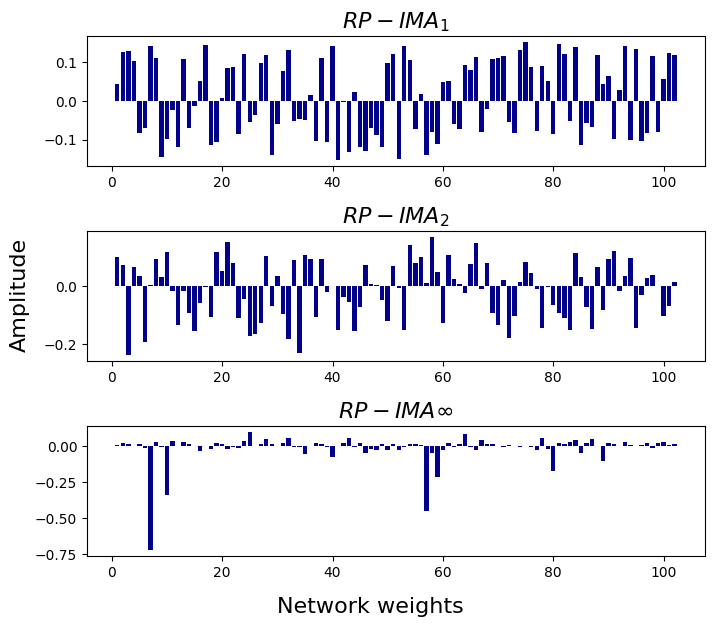

In [25]:
haberman = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/haberman/haberman.data', sep=",", header=None, engine='python')
y = haberman[3].to_numpy()
X = haberman.drop([3], axis='columns').to_numpy()
y[np.where(y==2)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 102, 0.1, 20, 10)
plot_weights(102, w_1, w_2, w_inf)

## Application on Transfusion Dataset

Parameters: p=249, eta=0.1, lambda=100


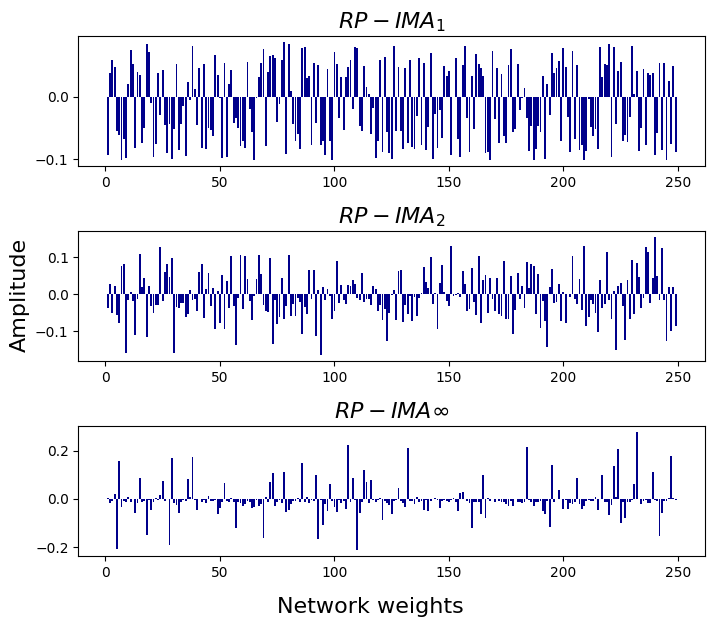

In [47]:
transfusion = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/transfusion/transfusion.data', sep=",", engine='python')
y = transfusion["whether he/she donated blood in March 2007"].to_numpy()
X = transfusion.drop(["whether he/she donated blood in March 2007"], axis='columns').to_numpy()
y[np.where(y==0)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 249, 0.1, 20, 100)
plot_weights(249, w_1, w_2, w_inf)

## Application on Australian Credit 

Parameters: p=230, eta=0.1, lambda=10


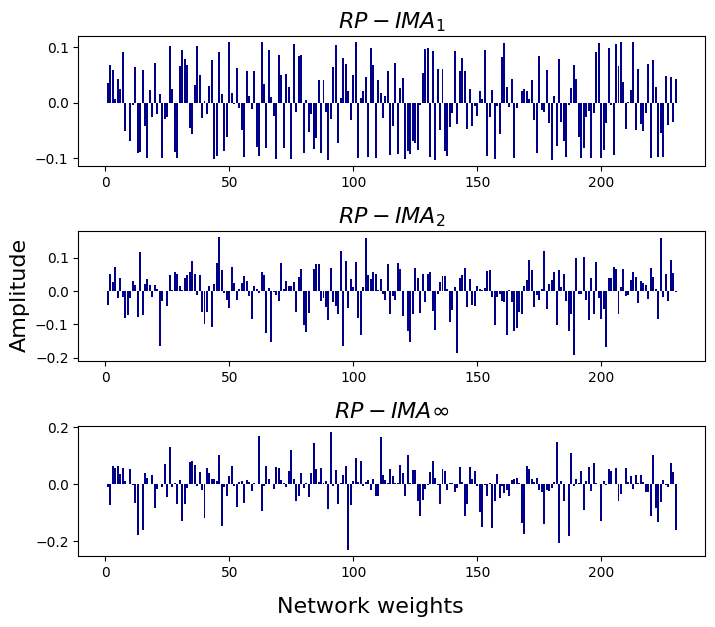

In [48]:
australian = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/australian_credit/australian.dat', header=None, sep=" ", engine='python')
australian = australian.replace("?", np.nan)
australian = australian.dropna()
y = australian[14].to_numpy()
X = australian.drop([14], axis='columns').to_numpy()
y[np.where(y==0)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 230, 0.1, 20, 10)
plot_weights(230, w_1, w_2, w_inf)

## Application on Breast Cancer Dataset

Parameters: p=227, eta=0.1, lambda=10


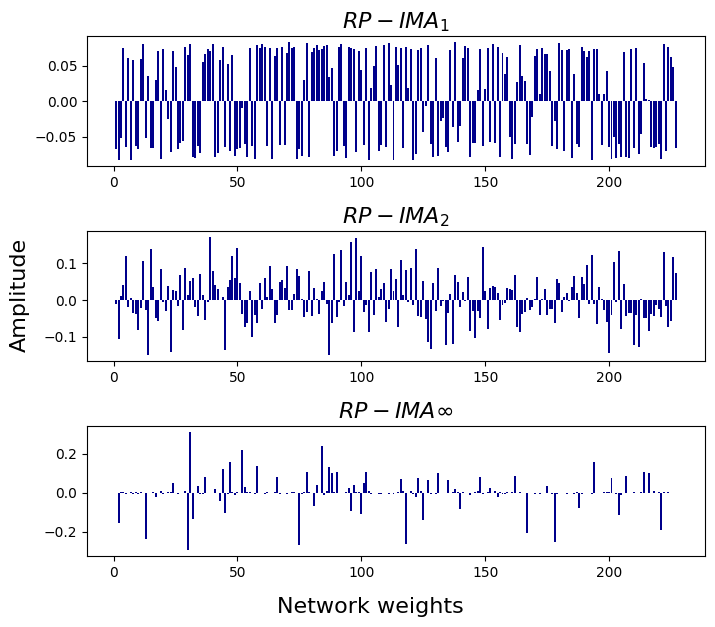

In [49]:
breast = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/breast/breast.data', header=None, sep=",", engine='python')
breast = breast.replace("?", np.nan)
breast = breast.dropna()
y = breast[10].to_numpy()
X = breast.drop([0, 10], axis='columns').to_numpy()
y[np.where(y==4)] = 1
y[np.where(y==2)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 227, 0.1, 20, 10)
plot_weights(227, w_1, w_2, w_inf)

## Application on Spam Dataset

Parameters: p=333, eta=0.1, lambda=100


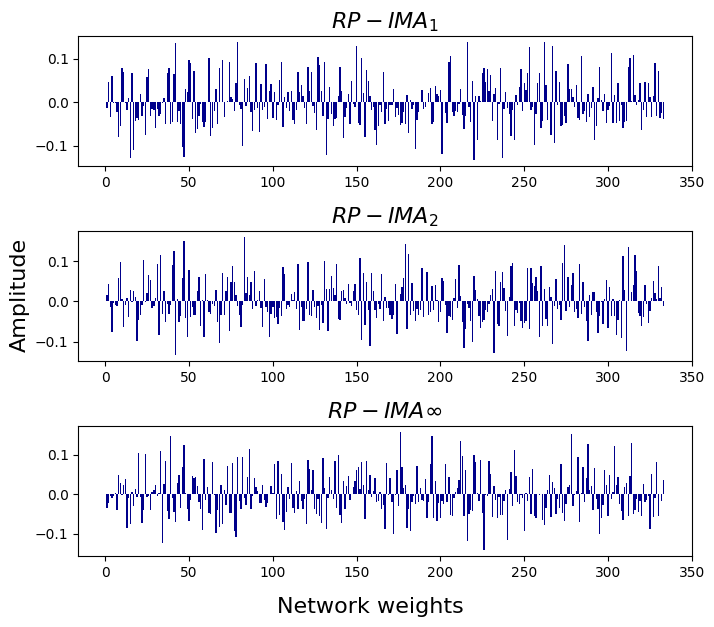

In [50]:
spam = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/spam/spambase.data', header=None, sep=",", engine='python')
y = spam[57].to_numpy()
X = spam.drop([57], axis='columns').to_numpy()
y[np.where(y==0)] = -1
y = np.array(y.tolist())
w_rbf, w_1, w_2, w_inf = results(X, y, 333, 0.1, 20, 100)
plot_weights(333, w_1, w_2, w_inf)